In [2]:
import os
import uuid
import cv2
import numpy as np
from tqdm import tqdm
from imutils import paths
import face_recognition
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams, PointStruct

# Configuration
COLLECTION_NAME = "image_facesv2"
BATCH_SIZE = 10

def safe_load_image(image_path):
    """Safely load an image with error handling"""
    try:
        # Use OpenCV to read image
        image = cv2.imread(image_path)
        if image is None:
            print(f"[ERROR] Unable to read image: {image_path}")
            return None
        
        # Convert to RGB
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return rgb_image
    except Exception as e:
        print(f"[ERROR] Error processing {image_path}: {str(e)}")
        return None

def process_images(dataset_path, qdrant_client):
    """Process images and store face encodings"""
    # Get all image paths
    image_paths = list(paths.list_images(dataset_path))
    
    print(f"[INFO] Total images found: {len(image_paths)}")
    
    # Batch processing
    for i in range(0, len(image_paths), BATCH_SIZE):
        batch_paths = image_paths[i:i + BATCH_SIZE]
        batch_points = []
        
        for image_path in tqdm(batch_paths, desc="Processing images"):
            # Load image
            rgb_image = safe_load_image(image_path)
            if rgb_image is None:
                continue
            
            # Detect faces
            try:
                # Try HOG first (faster)
                boxes = face_recognition.face_locations(rgb_image, model="hog")
            except Exception:
                # Fallback to CNN
                boxes = face_recognition.face_locations(rgb_image, model="cnn")
            
            # Compute face encodings
            encodings = face_recognition.face_encodings(rgb_image, boxes)
            
            # Create Qdrant points
            for box, encoding in zip(boxes, encodings):
                if len(encoding) == 128:
                    point_id = str(uuid.uuid4())
                    metadata = {
                        "imagePath": image_path,
                        "location": [int(x) for x in box]
                    }
                    
                    point = PointStruct(
                        id=point_id,
                        vector=encoding.tolist(),
                        payload=metadata
                    )
                    batch_points.append(point)
        
        # Upsert batch to Qdrant
        if batch_points:
            try:
                qdrant_client.upsert(
                    collection_name=COLLECTION_NAME,
                    points=batch_points
                )
                print(f"[INFO] Saved {len(batch_points)} face encodings")
            except Exception as e:
                print(f"[ERROR] Qdrant upsert failed: {str(e)}")

def main():
    # Qdrant Client Configuration
    try:
        qdrant_client = QdrantClient(
            url=os.getenv("QDRANT_URL"),
            api_key=os.getenv("QDRANT_API_KEY")
        )
        
        # Ensure collection exists
        try:
            qdrant_client.get_collection(COLLECTION_NAME)
            print(f"[INFO] Collection '{COLLECTION_NAME}' already exists.")
        except:
            # Create collection if it doesn't exist
            qdrant_client.create_collection(
                collection_name=COLLECTION_NAME,
                vectors_config=VectorParams(
                    size=128,
                    distance=Distance.COSINE
                )
            )
            print(f"[INFO] Created collection '{COLLECTION_NAME}'")
        
        # Process images
        process_images("dataset", qdrant_client)
    
    except Exception as e:
        print(f"[CRITICAL ERROR] {str(e)}")

if __name__ == "__main__":
    main()

[INFO] Created collection 'image_facesv2'
[INFO] Total images found: 130


Processing images: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


[INFO] Saved 12 face encodings


Processing images: 100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


[INFO] Saved 10 face encodings


Processing images: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


[INFO] Saved 10 face encodings


Processing images: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


[INFO] Saved 9 face encodings


Processing images: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


[INFO] Saved 12 face encodings


Processing images: 100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


[INFO] Saved 10 face encodings


Processing images: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


[INFO] Saved 9 face encodings


Processing images:  30%|███       | 3/10 [00:03<00:08,  1.19s/it]


KeyboardInterrupt: 

[INFO] Fetching data from Qdrant...
[INFO] Successfully fetched 132 valid encodings
[INFO] Clustering embeddings...
[INFO] Number of clusters found: 7
[INFO] Generating summary images...


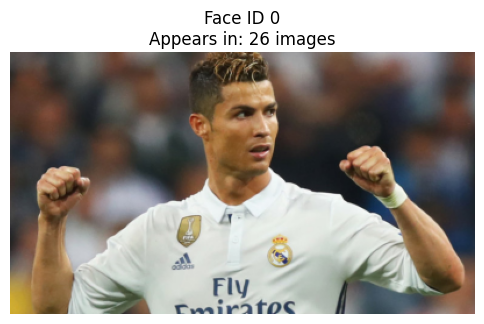

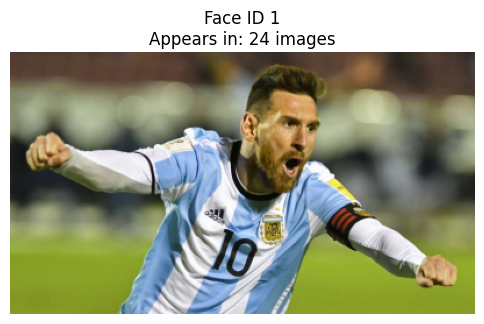

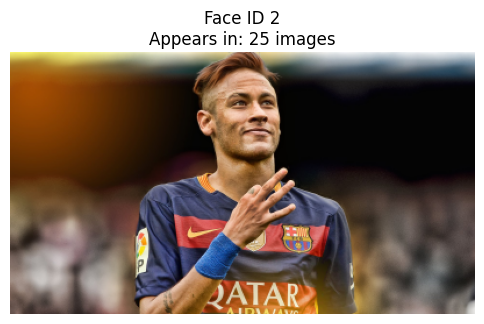

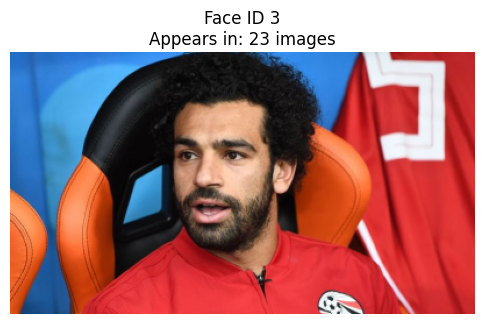

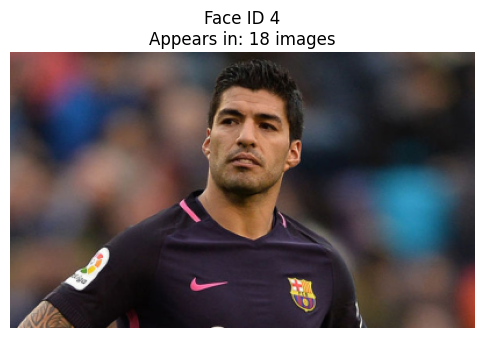

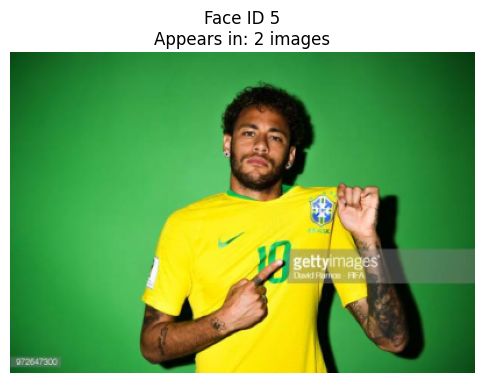

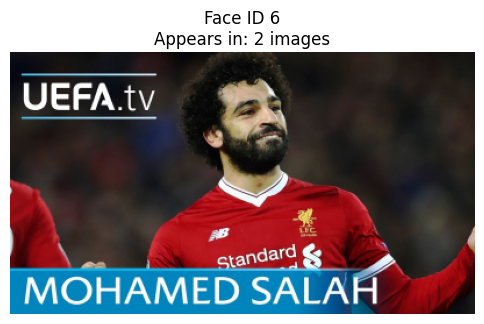

In [3]:
# clustering.py
from sklearn.cluster import DBSCAN
import numpy as np
import cv2
import os
from qdrant_client import QdrantClient
import matplotlib.pyplot as plt

# Qdrant Configuration
QDRANT_URL = os.getenv("QDRANT_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")
COLLECTION_NAME = "image_faces"

# Clustering parameters
DBSCAN_EPS = 0.3  # Experiment with this value (smaller -> more clusters)
DBSCAN_MIN_SAMPLES = 2  # Lower to form smaller clusters

qdrant_client = QdrantClient(url=QDRANT_URL, api_key=QDRANT_API_KEY)

def fetch_data_from_qdrant():
    print("[INFO] Fetching data from Qdrant...")
    encodings = []
    data = []
    try:
        response, next_offset = qdrant_client.scroll(
            collection_name=COLLECTION_NAME,
            with_payload=True,
            with_vectors=True,
            limit=10000
        )
        
        while response:
            for point in response:
                if hasattr(point, 'vector') and point.vector:
                    encodings.append(point.vector)
                    data.append(point.payload)

            if next_offset is None:
                break

            response, next_offset = qdrant_client.scroll(
                collection_name=COLLECTION_NAME,
                with_payload=True,
                with_vectors=True,
                limit=10000,
                offset=next_offset
            )

        print(f"[INFO] Successfully fetched {len(encodings)} valid encodings")
        return encodings, data

    except Exception as e:
        print(f"[ERROR] Error fetching data from Qdrant: {str(e)}")
        return [], []

def cluster_encodings(encodings):
    print("[INFO] Clustering embeddings...")
    clt = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES, metric='euclidean', n_jobs=-1)
    clt.fit(encodings)
    labels = clt.labels_
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"[INFO] Number of clusters found: {num_clusters}")
    return labels

def create_summary_images(labels, data):
    """Generate summary images and display them."""
    print("[INFO] Generating summary images...")

    face_appearance = {}

    for i, label in enumerate(labels):
        if label != -1:  # Ignore outliers labeled as -1
            if label not in face_appearance:
                face_appearance[label] = {
                    "image_paths": [],
                    "num_images": 0
                }

            face_appearance[label]["num_images"] += 1
            face_appearance[label]["image_paths"].append(data[i]["imagePath"])

    for face_id, info in sorted(face_appearance.items()):
        image_path = info["image_paths"][0]  # Pick the first image as representative
        image = cv2.imread(image_path)

        if image is not None:
            # Resize the image for display while maintaining the aspect ratio
            h, w = image.shape[:2]
            new_width = 400  # Adjust the width for fitting into display
            new_height = int((new_width / w) * h)
            resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

            num_images = info["num_images"]

            # Prepare for display
            plt.figure(figsize=(6, 6))
            plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f"Face ID {face_id}\nAppears in: {num_images} images", fontsize=12)
            plt.show()

def main():
    encodings, data = fetch_data_from_qdrant()

    if not encodings:
        print("[ERROR] No valid encodings found in Qdrant. Exiting.")
        return

    labels = cluster_encodings(encodings)
    create_summary_images(labels, data)

if __name__ == "__main__":
    main()

In [1]:
import os
import numpy as np
from qdrant_client import QdrantClient
import face_recognition
import matplotlib.pyplot as plt
import cv2

class QdrantImageDebugger:
    def __init__(self):
        # Qdrant Configuration
        self.QDRANT_URL = os.getenv("QDRANT_URL")
        self.QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")
        self.COLLECTION_NAME = "image_faces"

        # Initialize Qdrant Client
        self.qdrant_client = QdrantClient(
            url=self.QDRANT_URL,
            api_key=self.QDRANT_API_KEY
        )

    def debug_qdrant_collection(self, query_image_path):
        """Load and encode query image, then find similar images in Qdrant."""
        try:
            query_image = face_recognition.load_image_file(query_image_path)
            print(f"[DEBUG] Loaded image shape: {query_image.shape}")
        except Exception as e:
            print(f"[ERROR] Failed to load image: {e}")
            return

        query_face_locations = face_recognition.face_locations(query_image)
        query_encodings = face_recognition.face_encodings(query_image, query_face_locations)

        if not query_encodings:
            print("[ERROR] No faces detected in query image")
            return

        query_encoding = query_encodings[0]
        print(f"[DEBUG] Query encoding shape: {query_encoding.shape}")

        # Fetch all points from Qdrant
        all_points = []
        next_offset = None

        print("[INFO] Fetching all points from Qdrant...")
        while True:
            response = self.qdrant_client.scroll(
                collection_name=self.COLLECTION_NAME,
                with_payload=True,
                with_vectors=True,
                limit=1000,
                offset=next_offset
            )

            if response:
                all_points.extend(response[0])
                next_offset = response[1]
                if next_offset is None:
                    break
            else:
                break

        print(f"[DEBUG] Total points fetched: {len(all_points)}")

        if len(all_points) == 0:
            print("[ERROR] No points found in the collection. Cannot proceed with debugging.")
            return

        # Configure similarity threshold
        threshold = 0.64

        # Compute matches with detailed tracking
        image_matches = {}
        total_matches = 0

        for point in all_points:
            if not hasattr(point, 'vector') or not point.vector:
                continue

            # Compute face similarity
            try:
                distance = face_recognition.face_distance(
                    [np.array(point.vector)], 
                    query_encoding
                )[0]
                
                # Check if the face is a match based on the threshold
                if distance <= threshold:
                    image_path = point.payload.get('imagePath')
                    if image_path:
                        total_matches += 1
                        if image_path not in image_matches:
                            image_matches[image_path] = 1
                        else:
                            image_matches[image_path] += 1

            except Exception as e:
                print(f"[ERROR] Face comparison error: {e}")

        if not image_matches:
            print("[ERROR] No matches found above threshold.")
            return

        # Select the image with the highest match count
        best_match_image = max(image_matches, key=image_matches.get)
        best_match_count = image_matches[best_match_image]

        print(f"[RESULT] Total Matches: {total_matches}")
        print(f"[RESULT] Best matching image: {best_match_image}, Match Count: {best_match_count}")

        # Display the best matching image
        self.display_single_image(best_match_image, total_matches)

    def display_single_image(self, image_path, total_matches):
        """Display a single image with the total match count."""
        image = cv2.imread(image_path)
        if image is not None:
            # Resize the image for display
            h, w = image.shape[:2]
            new_width = 400
            new_height = int((new_width / w) * h)
            resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

            # Display with total match count
            plt.figure(figsize=(8, 6))
            plt.suptitle(f"Total Matches: {total_matches}", fontsize=14)
            plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f"Image: {os.path.basename(image_path)}", fontsize=12)
            plt.show()

def main():
    # Path to your query image
    query_image_path = 'C:/Greg-Galvin-Unique-Faces-and-Object-Identification/dataset/00000027.jpg'

    # Initialize debugger
    debugger = QdrantImageDebugger()

    # Run comprehensive debug
    debugger.debug_qdrant_collection(query_image_path)

if __name__ == "__main__":
    main()

[DEBUG] Loaded image shape: (297, 220, 3)
[DEBUG] Query encoding shape: (128,)
[INFO] Fetching all points from Qdrant...


UnexpectedResponse: Unexpected Response: 404 (Not Found)
Raw response content:
b'404 page not found\n'